# Crop Type Classification - ML model building and optimisation

This notebook demonstrates how to build and tune a machine learning model to classify crop types on NDVI timeseries and bhuvan fasal GT. 

### Conda environment setup
Before running this notebook, let's build a conda environment. If you do not have conda installed, please follow the instructions from [Conda User Guide](https://docs.conda.io/projects/conda/en/latest/user-guide/index.html). 

```
$ conda create --name 'env_name' --file requirements.txt
$ conda activate 'env_name'
```

### Key Libraries:

- [XGBoost](https://xgboost.readthedocs.io/en/stable/): ML model for crop type classification.
- [Geopandas](https://geopandas.org/en/stable/docs.html), [Pandas]((https://xgboost.readthedocs.io/en/stable/)): Data handling and manipulation.
- [Matplotlib](https://matplotlib.org/stable/index.html), [Seaborn](https://seaborn.pydata.org/tutorial.html): Utilized for data visualization.
- [Scikit-learn](https://scikit-learn.org/stable/user_guide.html): For scaling data, obtaining relevant metrics etc.

### Modelling details:
- Model Type: XGBoost
- ML Task: Multiclass classification
- Crop Types (Target): mustard, wheat and potato
- Target Metric: harmonic mean of precision w.r.t each crop class. Formula: 3/(1/PrMustard + 1/PrWheat + 1/PrPotato) (Note: Pr is Precision)

--------

# Module and data imports

In [5]:
import os

try:
    if kernel_is_loaded:
        pass
except:
    os.chdir('/'.join(os.getcwd().split('/')[:-1]))
    kernel_is_loaded = True

from glob import glob
import geopandas as gp
import numpy as np
import pandas as pd
import random
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import ParameterGrid

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 20

# Seeding
def seed_everything(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    
seed_everything()

In [4]:
# Importing train, validation and test sets. 

train = pd.read_csv('data_files/train.csv')
val = pd.read_csv('data_files/val.csv')
test = pd.read_csv('data_files/test.csv')

# Predictor and label split

In [7]:
X_train = train.drop('crop_name', axis=1)
y_train = train['crop_name']

X_val = val.drop('crop_name', axis=1)
y_val = val['crop_name']

X_test = test.drop('crop_name', axis=1)
y_test = test['crop_name']

# Modelling

In [14]:
fort_nights = list(X_train.loc[:, 'oct_1f':'apr_2f'].columns)

params = {'n_estimators':np.arange(5,100,5), 'learning_rate':np.arange(0.05, 0.55, 0.05), 
          'max_depth':np.arange(1,5,1)}

param_grid = list(ParameterGrid(params))
max_precision_scores = []
best_params = []
fns_used = []

i = 0

while (i + 4) <= len(fort_nights):
    precision_scores = []
    if i == 0:
        drop_cols = []
    else:
        drop_cols = fort_nights[-i:]
    for p in param_grid:
        wheat_classifier = XGBClassifier(**p)
        temp_X_train = X_train.drop(drop_cols, axis=1)
        temp_X_val = X_val.drop(drop_cols, axis=1)
        wheat_classifier.fit(temp_X_train, y_train)
        val_pred = wheat_classifier.predict(temp_X_val)
        precision, recall, f1score, support = score(y_val, val_pred, labels=[0,1,2])
        precision_scores.append(precision)
        
    precision_scores = pd.DataFrame(precision_scores)
    hms = precision_scores.apply(lambda row : len(row) / np.sum(1.0 / row), axis=1).values
    best_hm = np.max(hms)
    if best_hm != 0:
        best_hm_idx = np.argmax(hms)
        best_params.append(param_grid[best_hm_idx])
        max_precision_scores.append(best_hm)    
        fns_used.append('-'.join(map(str, temp_X_train.columns[[0,-1]])))
        print(i , 'fns dropped completed with best harmonic mean of', best_hm, 'precision on validation data')
    else:
        print(i , 'fns dropped completed and unable to find atleast 0.85 precision on validation data w.r.t each class')
    
    i += 1
    
print('Done!!')

0 fns dropped completed with best harmonic mean of 0.9683868122551961 precision on validation data
1 fns dropped completed with best harmonic mean of 0.9625092872146289 precision on validation data
2 fns dropped completed with best harmonic mean of 0.9656143862071941 precision on validation data
3 fns dropped completed with best harmonic mean of 0.9593666401189969 precision on validation data
4 fns dropped completed with best harmonic mean of 0.94736742480589 precision on validation data
5 fns dropped completed with best harmonic mean of 0.932249277057785 precision on validation data
6 fns dropped completed with best harmonic mean of 0.9193139803661428 precision on validation data
7 fns dropped completed with best harmonic mean of 0.9142321506563857 precision on validation data
8 fns dropped completed with best harmonic mean of 0.9024564612654807 precision on validation data
9 fns dropped completed with best harmonic mean of 0.8782878118537093 precision on validation data
10 fns droppe

In [15]:
max_precision_scores

[0.9683868122551961,
 0.9625092872146289,
 0.9656143862071941,
 0.9593666401189969,
 0.94736742480589,
 0.932249277057785,
 0.9193139803661428,
 0.9142321506563857,
 0.9024564612654807,
 0.8782878118537093,
 0.8702042425321591]

In [16]:
test_reports = []
test_precision_scores = []
confusion_matrices = []
best_models = []

for i in range(len(fns_used)):
    best_classifier = XGBClassifier(**best_params[i])
    
    strt_fn, end_fn = fns_used[i].split('-')
    temp_X_train = X_train.loc[:, strt_fn:end_fn]
    temp_X_test = X_test.loc[:, strt_fn:end_fn]
    best_classifier.fit(temp_X_train, y_train)
    best_models.append(best_classifier)
    test_pred = best_classifier.predict(temp_X_test)
    report = classification_report(y_test, test_pred, target_names=['Mustard', 'Wheat','Potato'], output_dict=True)
    df = pd.DataFrame(report).transpose().loc[:'Potato',:'f1-score']
    test_reports.append(df)
    test_precision_scores.append(df['precision'].values)
    print(fns_used[i])
    display(test_reports[i])
    cf = pd.crosstab(y_test, pd.Series(test_pred, name='pred')).rename({0:'Mustard', 1:'Wheat',2:'Potato'}).rename({0:'Mustard', 1:'Wheat',2:'Potato'}, axis=1)
    confusion_matrices.append(cf)

oct_1f-apr_2f


,precision,recall,f1-score
Mustard,0.939173,0.925659,0.932367
Wheat,0.987141,0.996183,0.991641
Potato,0.974922,0.965839,0.970359


oct_1f-apr_1f


,precision,recall,f1-score
Mustard,0.932530,0.928058,0.930288
Wheat,0.988645,0.996947,0.992778
Potato,0.973228,0.959627,0.966380


oct_1f-mar_2f


,precision,recall,f1-score
Mustard,0.922518,0.913669,0.918072
Wheat,0.988662,0.998473,0.993543
Potato,0.963780,0.950311,0.956998


oct_1f-mar_1f


,precision,recall,f1-score
Mustard,0.925301,0.920863,0.923077
Wheat,0.991629,0.994656,0.993140
Potato,0.956386,0.953416,0.954899


oct_1f-feb_2f


,precision,recall,f1-score
Mustard,0.911271,0.911271,0.911271
Wheat,0.987842,0.992366,0.990099
Potato,0.956113,0.947205,0.951638


oct_1f-feb_1f


,precision,recall,f1-score
Mustard,0.878571,0.884892,0.881720
Wheat,0.987043,0.988550,0.987796
Potato,0.932707,0.925466,0.929072


oct_1f-jan_2f


,precision,recall,f1-score
Mustard,0.876812,0.870504,0.873646
Wheat,0.987768,0.986260,0.987013
Potato,0.922958,0.930124,0.926527


oct_1f-jan_1f


,precision,recall,f1-score
Mustard,0.849642,0.853717,0.851675
Wheat,0.984721,0.983969,0.984345
Potato,0.912908,0.911491,0.912199


oct_1f-dec_2f


,precision,recall,f1-score
Mustard,0.828571,0.834532,0.831541
Wheat,0.974242,0.981679,0.977947
Potato,0.914422,0.895963,0.905098


oct_1f-dec_1f


,precision,recall,f1-score
Mustard,0.797531,0.774580,0.785888
Wheat,0.949737,0.966412,0.958002
Potato,0.883096,0.868012,0.875489


oct_1f-nov_2f


,precision,recall,f1-score
Mustard,0.787952,0.784173,0.786058
Wheat,0.949025,0.966412,0.957640
Potato,0.877814,0.847826,0.862559


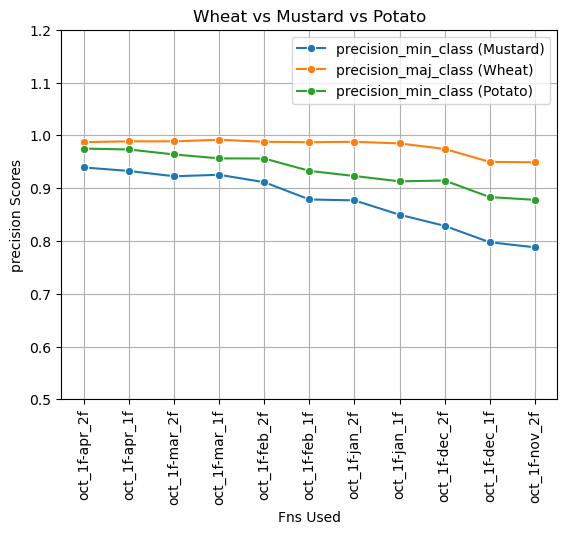

In [17]:
sns.lineplot(y=np.array(test_precision_scores)[:,0], x=fns_used, label='precision_min_class (Mustard)', marker="o")
sns.lineplot(y=np.array(test_precision_scores)[:,1], x=fns_used, label='precision_maj_class (Wheat)', marker="o")
sns.lineplot(y=np.array(test_precision_scores)[:,2], x=fns_used, label='precision_min_class (Potato)', marker="o")
plt.xlabel('Fns Used')
plt.ylabel('precision Scores')
plt.xticks(rotation='vertical')
plt.title('Wheat vs Mustard vs Potato')
plt.ylim([0.5,1.2])
plt.grid()
plt.show()

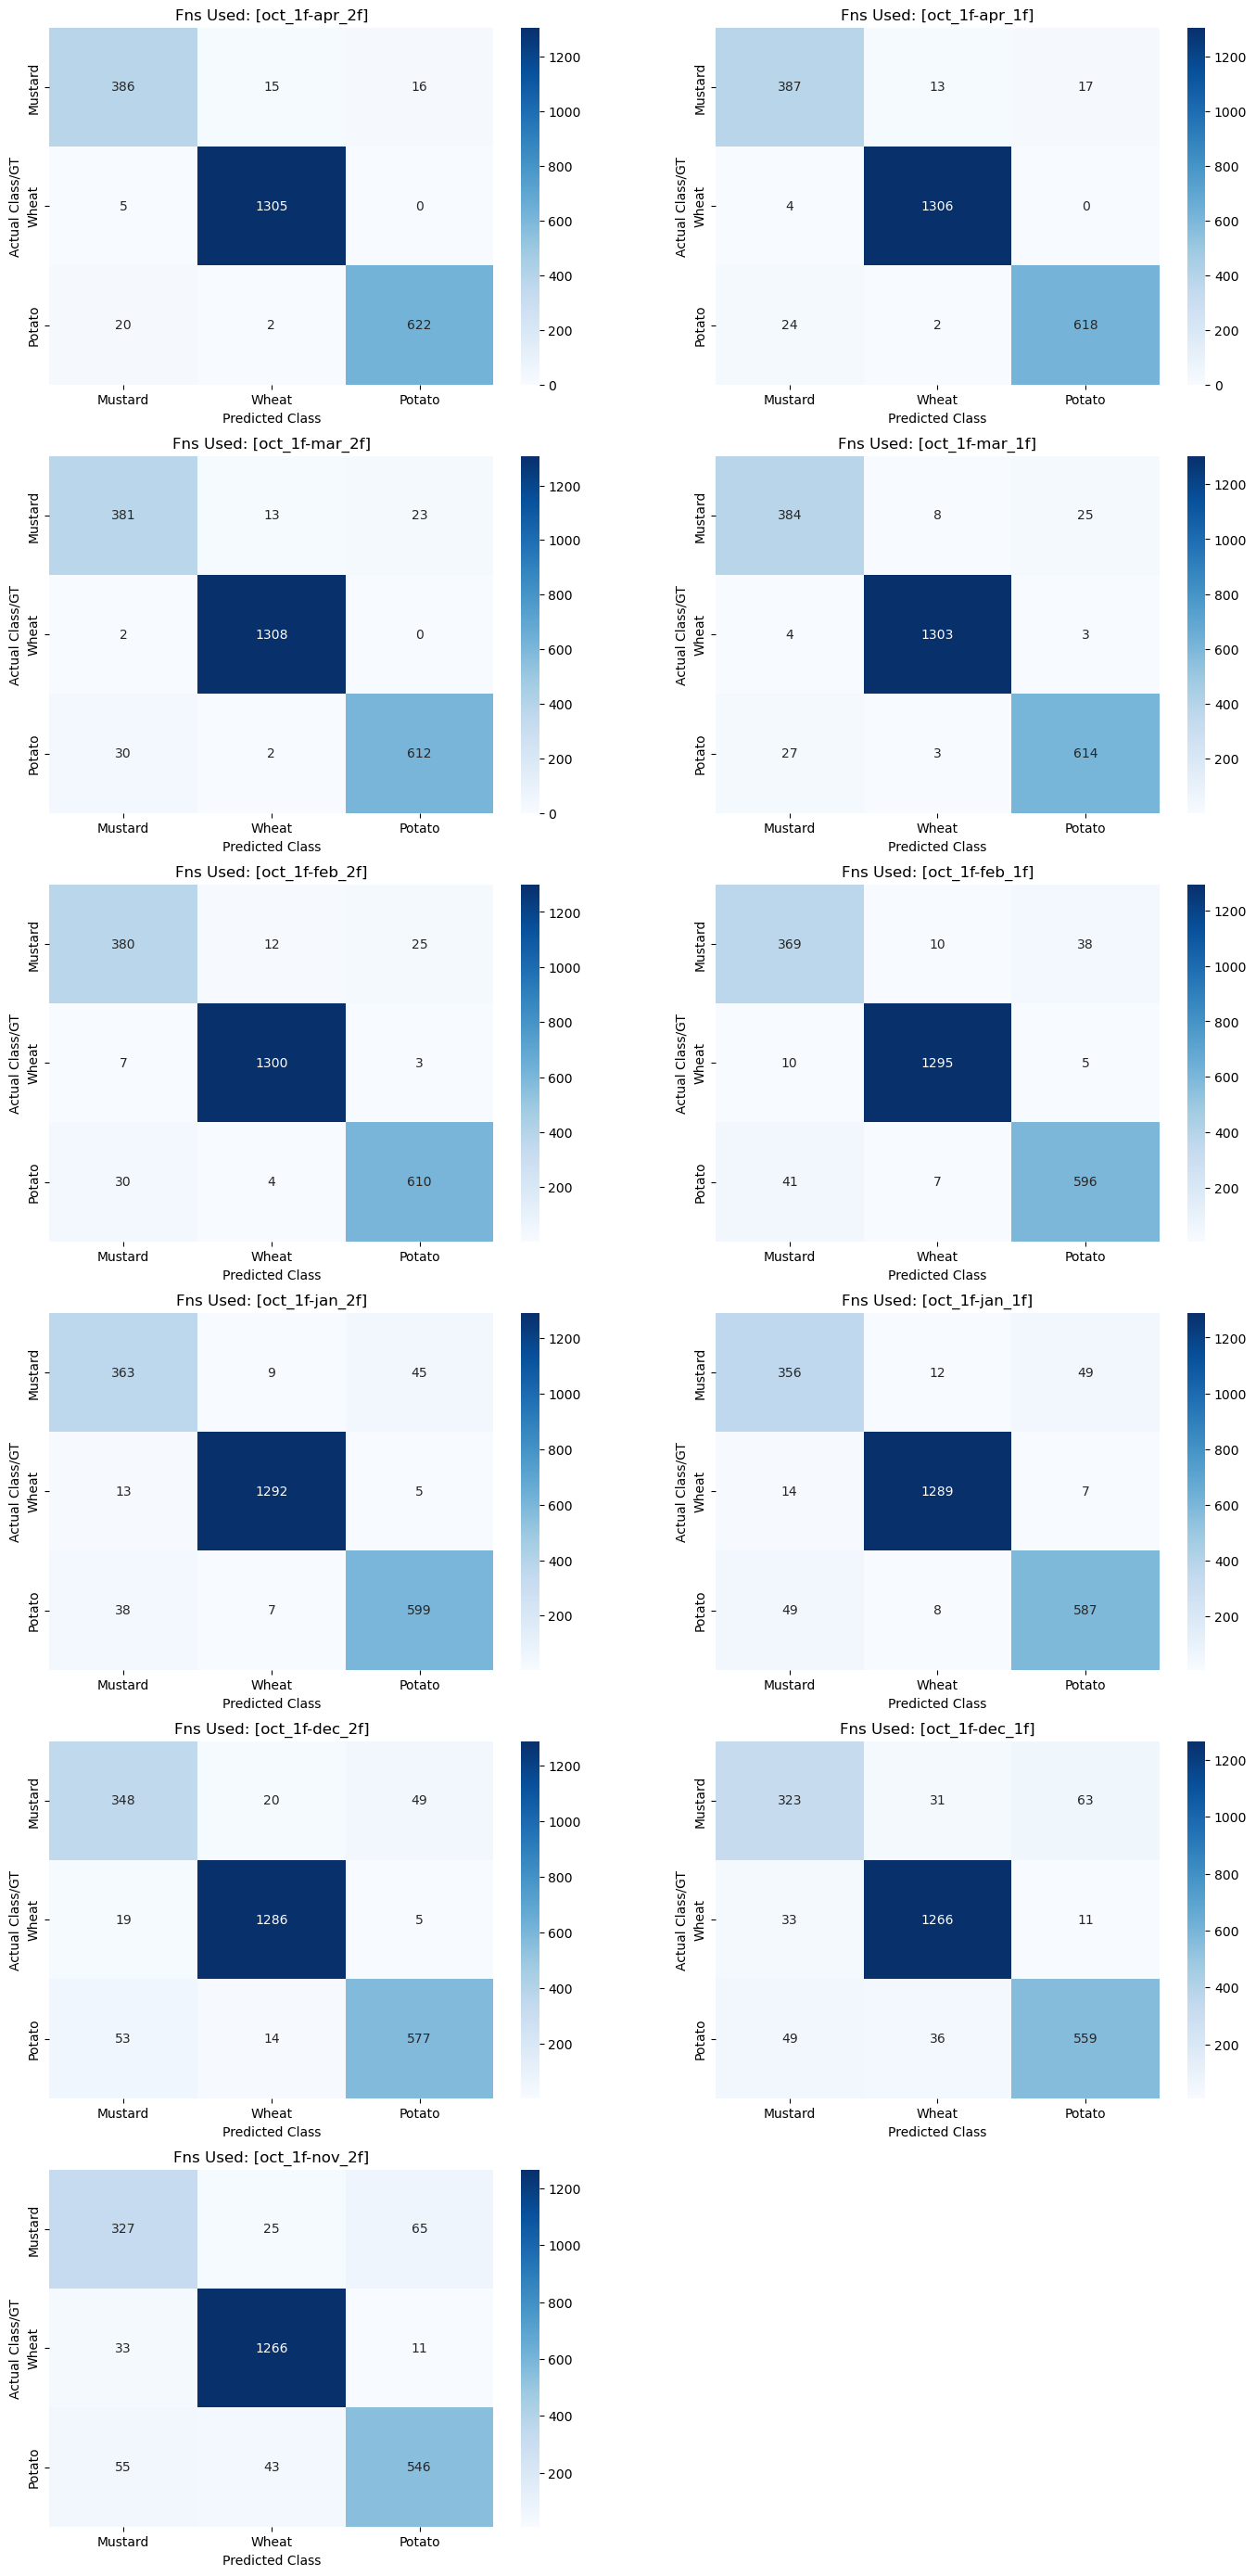

In [20]:
plt.figure(figsize=(17,35))

for i in range(len(confusion_matrices)):
    plt.subplot(6,2,i+1)
    sns.heatmap(confusion_matrices[i], annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class/GT')
    plt.title(f'Fns Used: [{fns_used[i]}]')
plt.show()